# The Kalman Filter

References:

* [1] "Data assimilation. Methods, algorithms and applications."
Marc Asch, Marc Bocquet, Maelle Nodet. 
SIAM (2006).
Chapter 3: Statistical estimation and sequential data assimilation. p.71

## Model

We estimate a state $x\in\mathbb{R}^n$ of a discrete-time stochastic process [1,p.91]:
$$
x_{k+1} = M_{k+1} x_k + w_k
$$
for $k=1,2,...$, where $M_{k+1}\in\mathbb{R}^{n\times n}$ is the real transition matrix and $w_k$ is a gaussian random variable with zero mean:
$$
w_k \sim \mathcal{N}(0,Q_k),
$$
where $Q_k$ is the covariance matrix of the state. 

We observe the variable $y\in\mathbb{R}^m$:
$$
y_k = H_k x_k + v_k
$$
for $k=1,2,...$, where $H_k\in\mathbb{R}^{m\times n}$ is the real observation matrix and $v_k$ is a gaussian random variable with zero mean:
$$
v_k \sim \mathcal{N}(0,R_k),
$$
where $R_k$ is the covariance matrix of the observation. 

## Theory

The Kalman filter implements the following steps[1,p.96].

* Inputs: $x_k^a$, $M_{k+1}$, $P_k^a$, $Q_k$, $R_k$, $H_k$
* Outputs: $x_{k+1}^f$, $P_{k+1}^f$, $x_{k+1}^a$, $P_{k+1}^a$
* Time update : predict

  * Compute the forecast (i.e. the prior): 
$$
x_{k+1}^f = M_{k+1} x_k^a
$$

 
  * Compute the error covariance (i.e. the prior covariance):
$$
P_{k+1}^f = M_{k+1} P_k^a M_{k+1}^T + Q_k
$$

* Correct
  * Compute the Kalman gain:
$$
K_{k+1} = P_{k+1}^f H_k^T (H_k P_{k+1}^f H_k^T + R_k)^{-1}
$$

  * Update the analysis state (i.e. the posterior):
$$
x_{k+1}^a = x_{k+1}^f + K_{k+1} (y_{k+1} - H_k x_{k+1}^f)
$$

  * Update the covariance of the analysis state (i.e. the posterior covariance):
$$
P_{k+1}^a = (I - K_{k+1} H_k) P_{k+1}^f
$$

In [1]:
import openturns as ot
import numpy as np
from openturns.viewer import View

In [2]:
'''
An attempt to implement the Kalman Filter.
'''

def matrixInverse(A):
    IA = ot.IdentityMatrix(A.getNbRows())
    invA = A.solveLinearSystem(IA)
    return invA

class KalmanFilter:
    def __init__(self,x,M,P,Q,H,R):
        '''
        Create a new KalmanFilter.
        Parameters
        x: the initial value of the analysis (i.e. the posterior)
        '''
        self.x = x
        self.M = M
        self.P = P
        self.Q = Q
        self.H = H
        self.R = R
        self.verbose = False
        self.K = None

    def setVerbose(self,enableVerbose):
        self.verbose = enableVerbose
        return
    
    def update(self,y):
        # Prediction
        self.x = self.M * self.x
        self.P = self.M*self.P*self.M.transpose()+self.Q
        # Kalman gain
        self.K = self.P*self.H.transpose()*matrixInverse(self.H*self.P*self.H.transpose()+self.R)
        # Correction
        self.x = self.x + self.K*(y-self.H*self.x)
        self.P = self.P - self.K*self.H*self.P
        return
    
    def getState(self):
        return self.x

    def getPosteriorCovariance(self):
        return self.P

    def getKalmanGain(self):
        return self.K

## Example: brownian motion

See [1], Example 3.34, page 106

In [3]:
xa = ot.Point([0.])
P = ot.CovarianceMatrix([[0.]])

In [4]:
M= ot.CovarianceMatrix([[1.]])
Q= ot.CovarianceMatrix([[1.]])
R= ot.CovarianceMatrix([[0.25]])
H= ot.Matrix([[1.]])
kf = KalmanFilter(xa,M,P,Q,H,R)

In [5]:
y= ot.Normal(H*xa,R).getRealization()
print("    y",y)

    y [0.304101]


In [6]:
for i in range(5):
    y= ot.Normal(H*xa,R).getRealization()
    print("i=",i,"y=",y)
    kf.update(y)
    print("    x=",kf.getState(),"    K=",kf.getKalmanGain(),"    Pa=",kf.getPosteriorCovariance())

i= 0 y= [-0.633087]
    x= [-0.506469]     K= [[ 0.8 ]]     Pa= [[ 0.2 ]]
i= 1 y= [-0.219133]
    x= [-0.268674]     K= [[ 0.827586 ]]     Pa= [[ 0.206897 ]]
i= 2 y= [0.602739]
    x= [0.453207]     K= [[ 0.828402 ]]     Pa= [[ 0.207101 ]]
i= 3 y= [-1.09069]
    x= [-0.8258]     K= [[ 0.828426 ]]     Pa= [[ 0.207107 ]]
i= 4 y= [0.175021]
    x= [0.00330724]     K= [[ 0.828427 ]]     Pa= [[ 0.207107 ]]


## Example: estimation of a random constant

See [1], Example 3.35, page 108

In [7]:
xa = ot.Point([-0.37727])
P = ot.CovarianceMatrix([[0.]])

In [8]:
M= ot.CovarianceMatrix([[1.]])
H= ot.Matrix([[1.]])
Q= ot.CovarianceMatrix([[1.e-5]])
R= ot.CovarianceMatrix([[0.01]])


In [9]:
def simulate(numberOfIterations,M,P,Q,H,R):
    kf = KalmanFilter(xa,M,P,Q,H,R)
    x = ot.Sample(numberOfIterations,1)
    y = ot.Sample(numberOfIterations,1)
    for i in range(numberOfIterations):
        yobs= ot.Normal(H*xa,R).getRealization()
        kf.update(yobs)
        y[i] = yobs
        x[i] = kf.getState()
    return x, y

In [10]:
def plotKF(x,y,R):
    n = x.getSize()
    graph = ot.Graph("Voltmeter - R=%s" % (R[0,0]),"Time","Volts",True,"topright")
    cloudx = ot.Cloud(ot.Sample(range(n),1),x[:,0])
    cloudx.setLegend("KS Estimation")
    graph.add(cloudx)
    cloudy = ot.Cloud(ot.Sample(range(n),1),y[:,0])
    cloudy.setLegend("Observations")
    cloudy.setColor("green")
    graph.add(cloudy)
    exact = g.draw(0,n-1)
    exact.setColors(["red"])
    exact.setLegends(["True"])
    graph.add(exact)
    return graph

In [11]:
g = ot.SymbolicFunction(["t"],["-0.37727"])

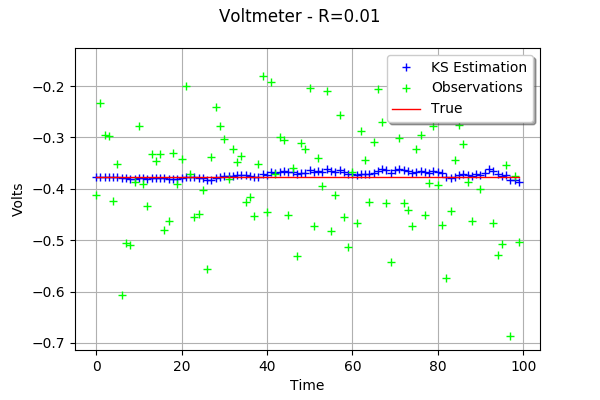

In [12]:
x, y = simulate(100,M,P,Q,H,R)
plotKF(x,y,R)

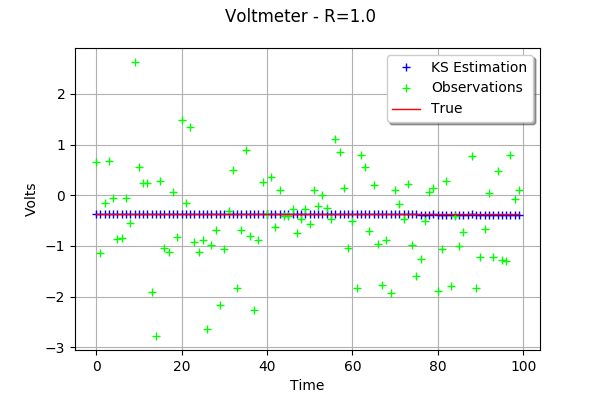

In [13]:
R= ot.CovarianceMatrix([[1.]])
x, y = simulate(100,M,P,Q,H,R)
plotKF(x,y,R)

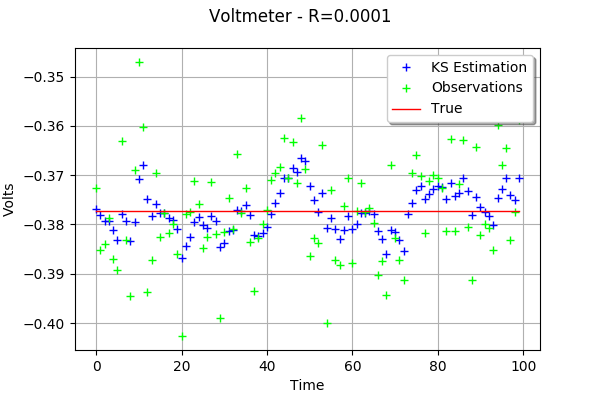

In [14]:
R= ot.CovarianceMatrix([[0.0001]])
x, y = simulate(100,M,P,Q,H,R)
plotKF(x,y,R)